In [39]:
# Split data
import shutil
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import image_dataset_from_directory

os.makedirs('data', exist_ok=True)
os.makedirs('data/train', exist_ok=True)
os.makedirs('data/test', exist_ok=True)
os.makedirs('data/val', exist_ok=True)

# Split data
IMAGES_PATH = 'images'
for category in os.listdir(IMAGES_PATH):
    if category.startswith('.'):
        continue
    os.makedirs(f'data/train/{category}', exist_ok=True)
    os.makedirs(f'data/test/{category}', exist_ok=True)
    os.makedirs(f'data/val/{category}', exist_ok=True)
    images = os.listdir(f'{IMAGES_PATH}/{category}')
    
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
    train_images, val_images = train_test_split(train_images, test_size=0.2, random_state=42)
    current_image_number = 0
    for image in train_images:
        if image.startswith('.'):
            continue
        image_name = category + str(current_image_number) + '.jpg'
        shutil.copy(f'{IMAGES_PATH}/{category}/{image}', f'data/train/{category}/{image_name}')
        current_image_number += 1
        
    for image in val_images:
        if image.startswith('.'):
            continue
        image_name = category + str(current_image_number) + '.jpg'
        shutil.copy(f'{IMAGES_PATH}/{category}/{image}', f'data/val/{category}/{image_name}')
        current_image_number += 1
        
    for image in test_images:
        if image.startswith('.'):
            continue
        image_name = category + str(current_image_number) + '.jpg'
        shutil.copy(f'{IMAGES_PATH}/{category}/{image}', f'data/test/{category}/{image_name}')
        current_image_number += 1
    

In [40]:
import pandas as pd
import os

data_dir = 'data'
image_paths = []
labels = []


for category in os.listdir(f'{data_dir}/train'):
    if category.startswith('.'):
        continue
    for image in os.listdir(f'{data_dir}/train/{category}'):
        image_paths.append(f'{data_dir}/train/{category}/{image}')
        labels.append(category.split('__')[1])      # Plant disease

train_df = pd.DataFrame({'filename': image_paths, 'label': labels})

image_paths = []
labels = []

for category in os.listdir(f'{data_dir}/val'):
    if category.startswith('.'):
        continue
    for image in os.listdir(f'{data_dir}/val/{category}'):
        image_paths.append(f'{data_dir}/val/{category}/{image}')
        labels.append(category.split('__')[1])      # Plant disease

val_df = pd.DataFrame({'filename': image_paths, 'label': labels})

image_paths = []
labels = []

for category in os.listdir(f'{data_dir}/test'):
    if category.startswith('.'):
        continue
    for image in os.listdir(f'{data_dir}/test/{category}'):
        image_paths.append(f'{data_dir}/test/{category}/{image}')
        labels.append(category.split('__')[1])      # Plant disease

test_df = pd.DataFrame({'filename': image_paths, 'label': labels})




In [41]:
#Prepare data after augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = 'data/train'
val_dir = 'data/val'
test_dir = 'data/test'

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range = [0.5, 1.5],
        fill_mode='nearest'
        )

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
        train_df,
        x_col='filename',
        y_col='label',
        target_size=(150, 150),
        batch_size=32,
        shuffle=True,
        class_mode='categorical')

val_generator = val_datagen.flow_from_dataframe(
        val_df,
        x_col='filename',
        y_col='label',
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')


Found 61309 validated image filenames belonging to 39 classes.
Found 15363 validated image filenames belonging to 39 classes.


In [42]:
# Description of the data
# Number of images in each category
print('Number of images in each category')
print('Train')
print(train_df['label'].value_counts())
NUM_CLASSES = len(train_df['label'].value_counts())



Number of images in each category
Train
label
_healthy                 13821
_mosaic_disease           8420
_citrus_greening          3524
_bacterial_spot           3466
_leaf_curl                3428
_late_blight              2513
_early_blight             2321
_powdery_mildew           1846
_bacterial_blight         1708
_green_mottle             1526
_black_measles            1452
_brown_streak_disease     1400
_brown_spot               1161
_black_rot                1151
_septoria_leaf_spot       1132
_rust                     1121
_spider_mites             1072
_blast                     921
_target_spot               898
_scab                      781
_common_rust               762
_leaf_scorch               709
_tungro                    691
_isariopsis_leaf_spot      688
_northern_leaf_blight      630
_leaf_mold                 608
_pests                     390
_bacterial_wilt            364
_virus                     340
_red_rot                   331
_gray_leaf_spot         

In [43]:
#Pre-trained model for plant leaves

from tensorflow.keras.applications import VGG16, Xception
from tensorflow.keras import layers, models, optimizers

conv_base = Xception(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3),
                  classes=1000,
    classifier_activation="softmax",)

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='softmax'))


conv_base.trainable = False
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 flatten_5 (Flatten)         (None, 51200)             0         
                                                                 
 dense_10 (Dense)            (None, 256)               13107456  
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 39)                10023     
                                                                 
Total params: 33,978,959
Trainable params: 13,117,479
Non-trainable params: 20,861,480
_________________________________________________________________


In [44]:
from keras import optimizers
model.compile(loss='categorical_crossentropy',
optimizer=optimizers.Adam(lr=1e-3),
metrics=['acc'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [45]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=60,
    validation_data=val_generator,
    validation_steps=50)

/tmp/ipykernel_3915339/911059594.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/60
100/100 [==============================] - 25s 229ms/step - loss: 3.7337 - acc: 0.0947 - val_loss: 3.2904 - val_acc: 0.2244
Epoch 2/60
100/100 [==============================] - 22s 222ms/step - loss: 3.1888 - acc: 0.2528 - val_loss: 3.0878 - val_acc: 0.3031
Epoch 3/60
100/100 [==============================] - 23s 226ms/step - loss: 2.9776 - acc: 0.3119 - val_loss: 2.9310 - val_acc: 0.3187
Epoch 4/60
100/100 [==============================] - 22s 223ms/step - loss: 2.8962 - acc: 0.3219 - val_loss: 2.8057 - val_acc: 0.3587
Epoch 5/60
100/100 [==============================] - 22s 220ms/step - loss: 2.7702 - acc: 0.3350 - val_loss: 2.7714 - val_acc: 0.3650
Epoch 6/60
100/100 [==============================] - 22s 221ms/step - loss: 2.6846 - acc: 0.3741 - val_loss: 2.6711 - val_acc: 0.3725
Epoch 7/60
100/100 [==============================] - 22s 222ms/step - loss: 2.6237 - acc: 0.3709 - val_loss: 2.6268 - val_acc: 0.4025
Epoch 8/60
100/100 [==============================] - 2

In [46]:
# Fine-tune the model
conv_base.trainable = True

model.compile(loss='categorical_crossentropy',
                optimizer=optimizers.Adam(lr=1e-6),
                metrics=['acc'])
model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=10,
    validation_data=val_generator,
    validation_steps=50)

/tmp/ipykernel_3915339/570386346.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/10
100/100 [==============================] - 27s 230ms/step - loss: 2.7373 - acc: 0.3241 - val_loss: 2.3295 - val_acc: 0.5469
Epoch 2/10
100/100 [==============================] - 22s 222ms/step - loss: 2.5416 - acc: 0.3847 - val_loss: 2.4799 - val_acc: 0.4969
Epoch 3/10
100/100 [==============================] - 22s 222ms/step - loss: 2.4478 - acc: 0.4078 - val_loss: 2.4163 - val_acc: 0.4812
Epoch 4/10
100/100 [==============================] - 22s 219ms/step - loss: 2.3687 - acc: 0.4197 - val_loss: 2.3073 - val_acc: 0.4919
Epoch 5/10
100/100 [==============================] - 22s 222ms/step - loss: 2.3347 - acc: 0.4378 - val_loss: 2.2465 - val_acc: 0.4950
Epoch 6/10
100/100 [==============================] - 22s 218ms/step - loss: 2.2880 - acc: 0.4316 - val_loss: 2.2096 - val_acc: 0.4963
Epoch 7/10
100/100 [==============================] - 23s 229ms/step - loss: 2.2219 - acc: 0.4572 - val_loss: 2.1171 - val_acc: 0.5156
Epoch 8/10
100/100 [==============================] - 2

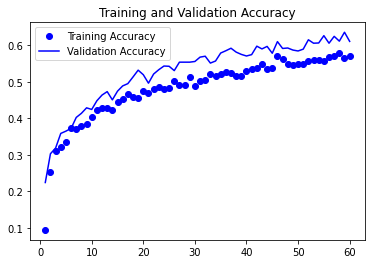

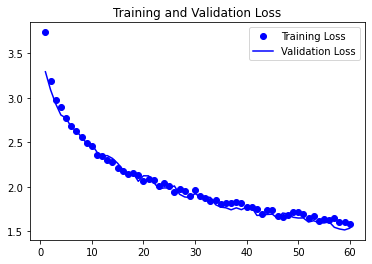

In [47]:
#Plot the results
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs = range(1,len(acc)+1)
plt.plot(epochs,acc,'bo',label='Training Accuracy')
plt.plot(epochs,val_acc,'b',label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'bo',label='Training Loss')
plt.plot(epochs,val_loss,'b',label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [48]:
# Test the model
test_generator = test_datagen.flow_from_dataframe(
        test_df,
        x_col='filename',
        y_col='label',
        target_size=(150, 150),
        batch_size=1,
        class_mode='categorical',
        shuffle=False
        )

test_loss, test_acc = model.evaluate(test_generator)
print('test acc:', test_acc)
print('test loss:', test_loss)


Found 19198 validated image filenames belonging to 39 classes.


/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1139: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


19198/19198 [==============================] - 144s 7ms/step - loss: 1.9810 - acc: 0.5430
test acc: 0.5429732203483582
test loss: 1.980977177619934


19198/19198 [==============================] - 80s 4ms/step


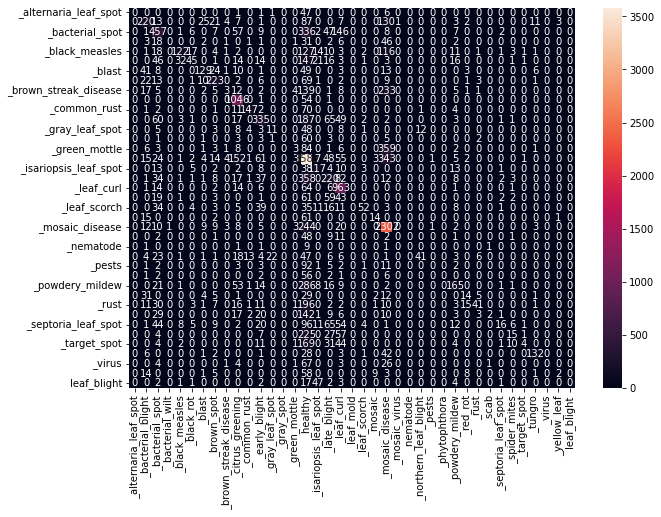

In [49]:
# Print the confusion matrix
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = np.array(test_generator.classes)

confusion_mtx = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(confusion_mtx, index = [i for i in test_generator.class_indices],
                  columns = [i for i in test_generator.class_indices])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')
plt.show()


In [50]:
# Display precision, recall, and F1-score of each class
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))



                       precision    recall  f1-score   support

_alternaria_leaf_spot       0.00      0.00      0.00        56
    _bacterial_blight       0.52      0.41      0.46       535
      _bacterial_spot       0.47      0.42      0.45      1086
      _bacterial_wilt       0.00      0.00      0.00       114
       _black_measles       0.70      0.27      0.39       455
           _black_rot       0.49      0.12      0.20       361
               _blast       0.67      0.45      0.54       288
          _brown_spot       0.61      0.61      0.61       363
_brown_streak_disease       0.16      0.01      0.01       438
     _citrus_greening       0.69      0.95      0.80      1102
         _common_rust       0.86      0.62      0.72       239
        _early_blight       0.53      0.46      0.49       726
      _gray_leaf_spot       0.31      0.11      0.16       103
           _gray_spot       0.00      0.00      0.00        79
        _green_mottle       0.18      0.01      0.01  

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
